# Spectroscopic factors

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ October 8, 2021

This notebook serves as a testbed for calculating spectroscopic overlaps using mean field approximations for initial and final states and applying SRG transformations to the operator. The normalization of spectroscopic overlaps give relative spectroscopic factors. The first step is to compute the overlap of $^4\rm{He}$ with $^3\rm{H}$ and compare to [VMC calculations](https://www.phy.anl.gov/theory/research/overlaps/).

_Last update:_ September 21, 2022

__To-do list:__
* Check if you need the $(-i)^l$ factor in the Hankel transformation function. The factor may cancel out in all relevant formulas (like the overlap wave function).
* Negative $1s_{1/2}$ wave function in $k$-space?
* Correct $\delta U^\dagger_{\beta \gamma \alpha \gamma}$ term. It does not include $\beta > 1s_{1/2}$ currently. The other two $\alpha$ and $\gamma$ are fine.
* Bug test the alternative approach.

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.special import spherical_jn

In [2]:
# Imports from A.T. codes
from scripts.figures import set_rc_parameters, label_nucleus, label_sp_state
from scripts.integration import (
    gaussian_quadrature_mesh, momentum_mesh, unattach_weights_from_matrix
)
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import find_index, replace_periods

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/spectroscopic_factors/'

# Load s.p. wave functions from the following directory
hfbrad_directory = '../data/dft/SLy4/'

## Functions

Move some of these functions into scripts at a later date.

In [5]:
def convert_l_to_string(l):
    """
    Returns the spectroscopic notation of the orbital angular momentum value
    l (e.g., l = 2 returns 'd').

    Parameters
    ----------
    l : int
        Orbital angular momentum of the single-particle (s.p.) state.

    Returns
    -------
    output : str
        Spectroscopic notation of s.p. state orbital angular momentum.

    """

    if l == 0:
        return 's'
    elif l == 1:
        return 'p'
    elif l == 2:
        return 'd'
    elif l == 3:
        return 'f'
    elif l == 4:
        return 'g'
    elif l == 5:
        return 'h'
    elif l == 6:
        return 'i'
    else:
        raise RuntimeError(
            "Input l value is outside the range of this function."
        )

In [6]:
def convert_l_to_int(sp_state):
    """
    Returns the orbital angular momentum given the s.p. state in spectroscopic 
    notation (e.g., '1d1p5' returns 2).

    Parameters
    ----------
    sp_state : str
        Spectroscopic notation of s.p. state (e.g., '1s0p5').

    Returns
    -------
    output : int
        Orbital angular momentum of the single-particle (s.p.) state.

    """
    
    if sp_state[1] == 's':
        return 0
    elif sp_state[1] == 'p':
        return 1       
    elif sp_state[1] == 'd':
        return 2
    elif sp_state[1] == 'f':
        return 3
    elif sp_state[1] == 'g':
        return 4
    elif sp_state[1] == 'h':
        return 5
    elif sp_state[1] == 'i':
        return 6
    else:
        raise RuntimeError(
            "Input s.p. state is outside the range of this function."
        )

In [7]:
def sp_states(nucleus_name, Z, N, print_info=False):
    """
    Return all the occupied single-particle states of the given nucleus.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'Ca40').
    Z : int
        Proton number.
    N : int
        Neutron number.
    print_statement : bool, optional
        Option to print information for each s.p. state in nucleus.
    
    Returns
    -------
    output : dict
        Dictionary with two keys: 'proton' and 'neutron'. Each corresponds to
        a list of all the occupied s.p. states, which are strings (e.g., '1s0p5'
        means 1s with j=1/2).
    
    Notes
    -----
    Currently we're assuming the SLy4 interaction.
    
    """

    # Go to HFBRAD directory
    densities_directory = f'../data/dft/SLy4/{nucleus_name}/'
    file_name = f'hfb_{N}_{Z}.spe'
    
    # Open file and add each occupied s.p. state to list
    neutron_states = []
    proton_states = []
    
    f = open(densities_directory + file_name, 'r')
    
    for line in f:
        
        unit = line.strip().split()  # Split up row into list
        
        # Make sure you're going through the correct data
        if (len(unit) == 12) and (unit[0] in ('1', '2')):
            
            # Only do occupied states:
            if float(unit[6]) == 1:
            
                # Integer specifying neutron or proton
                nucleon_number = unit[0]
        
                # j value
                j = int(unit[1])/2
        
                # Orbital angular momentum (int)
                l = int(unit[2])
                # Orbital angular momentum (str)
                l_str = convert_l_to_string(l)
        
                # Is this correct? (# of nodes)
                n = unit[11]
            
                # Convert s.p. state to string and append to list
                state_str = f'{n}{l_str}{j:.1f}'
            
                # Add string to neutron or proton list with periods replaced
                # by 'p'
                if nucleon_number == '1': # Neutron
                    neutron_states.append(replace_periods(state_str))
                elif nucleon_number == '2': # Proton
                    proton_states.append(replace_periods(state_str))
            
                # Print information for each state?
                if print_info:
                
                    info = (f"Nuc={nucleon_number}, N={unit[4]},"
                            f" state={state_str}")
                    print(info)
                
    f.close()
    
    return {'neutron' : neutron_states, 'proton' : proton_states}

In [8]:
def get_phi_rspace(nucleus_name, Z, N, nucleon, sp_state,
                   print_normalization=False):
    """Returns the single-particle wave function in coordinate space."""
    
    if nucleon == 'proton':
        nuc_int = 1
    elif nucleon == 'neutron':
        nuc_int = 0
    
    file_name = f'{nucleon}_{sp_state}_{N}_{Z}.gfx'
    
    data = np.loadtxt(hfbrad_directory + f"{nucleus_name}/wfs/{file_name}")

    r_array = data[:, 0]  # Units fm
    dr = r_array[1] - r_array[0]  # Linear spacing between r points
    phi_array = data[:, 2]  # Units fm^-1/2
    
    # These are normalized as \int dr |u(r)|^2 = 1
    if print_normalization:
        print(f"Normalization = {np.sum(dr*phi_array**2)}.")
    
    return r_array, phi_array

In [9]:
def plot_sp_wfs_rspace(nucleus_name, Z, N, x_limits=(0.0,10.0),
                       y_limits=(0.0,0.8), save=False):
    """Plot the s.p. wave functions of a nucleus in coordinate space."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Get the data
    d = sp_states(nucleus_name, Z, N)
    
    # Plot just the proton wave functions
    for i, sp_state in enumerate(d['proton']):
        
        r_array, phi_array = get_phi_rspace(nucleus_name, Z, N, 'proton',
                                            sp_state)
        
        ax.plot(r_array, phi_array, label=label_sp_state(sp_state),
                linewidth=2.0)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$r$ [fm]", fontsize=16)
    ax.set_ylabel(r"$u(r)$ [fm" + r'$^{-1/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_rspace_SLy4.png'
        f.savefig(figures_directory + file_name)

In [10]:
def hankel_transformation(l, k_array, r_array, dr):
    """
    <k|r> transformation matrix for given orbital angular momentum l. If
    len(r_array) = m and len(k_array) = n, then this function returns an 
    n x m matrix.
    
    Parameters
    ----------
    l : int
        Orbital angular momentum.
    k_array : 1-D ndarray
        Momentum array [fm^-1].
    r_array : 1-D ndarray
        Coordinates array [fm].
    dr : float
        Coordinates step-size (weight) [fm].
        
    Returns
    -------
    M : 2-D ndarray
        Hankel transformation matrix [fm^3\2].
        
    Notes
    -----
    There is a "missing" factor of r in the transformation matrix since the
    radial wave functions are already multiplied by r, meaning the
    normalization is \int dr |u(r)|^2 = 1 without the r^2.

    """
    
    # r_array column vectors and k_array row vectors where both grids are
    # n x m matrices
    r_cols, k_rows = np.meshgrid(r_array, k_array)
        
    # M = (-1j)**l * np.sqrt(2/np.pi) * dr * r_cols * spherical_jn(l, k_rows * r_cols)
    M = np.sqrt(2/np.pi) * dr * r_cols * spherical_jn(l, k_rows * r_cols)

    return M

In [11]:
def get_phi_kspace(nucleus_name, Z, N, nucleon, sp_state,
                   print_normalization=False):
    """Returns the single-particle wave function in momentum space."""
    
    # Set momentum mesh
    k_array, k_weights = momentum_mesh(15.0, 3.0, 120)
    
    # Get coordinate-space s.p. wave function
    r_array, phi_r_array = get_phi_rspace(nucleus_name, Z, N, nucleon, sp_state)
    dr = r_array[2] - r_array[1]  # Assuming linear spacing in coordinates
    
    # Fourier-transform the wave function to momentum space
    l = convert_l_to_int(sp_state)
    phi_k_array = hankel_transformation(l, k_array, r_array, dr) @ phi_r_array
    
    # These are normalized as \int dk k^2 |\phi(k)|^2 = 1
    if print_normalization:
        print(f"Normalization = {np.sum(k_weights*k_array**2*phi_k_array**2)}.")

    return k_array, k_weights, phi_k_array

In [12]:
def plot_sp_wfs_kspace(nucleus_name, Z, N, x_limits=(0.0,5.0),
                       y_limits=(-0.1,4.0), save=False):
    """Plot the s.p. wave functions of a nucleus in momentum space."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Get the data
    d = sp_states(nucleus_name, Z, N)
    
    # Plot just the proton wave functions
    for i, sp_state in enumerate(d['proton']):
        
        k_array, _, phi_array = get_phi_kspace(nucleus_name, Z, N, 'proton',
                                               sp_state)
        
        ax.plot(k_array, phi_array, label=label_sp_state(sp_state),
                linewidth=2.0)
        
    # Add horizontal line at y=0
    ax.axhline(0.0, color='gray', alpha=0.4, zorder=1)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$k$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$\phi(k)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_kspace_SLy4.png'
        f.savefig(figures_directory + file_name)

## Single-particle wave functions in coordinate space

In [13]:
nucleus_name, Z, N = 'He4', 2, 2

In [14]:
phi_r_array = get_phi_rspace(nucleus_name, Z, N, 'proton', '1s0p5',
                             print_normalization=True)

Normalization = 1.0000000007365384.


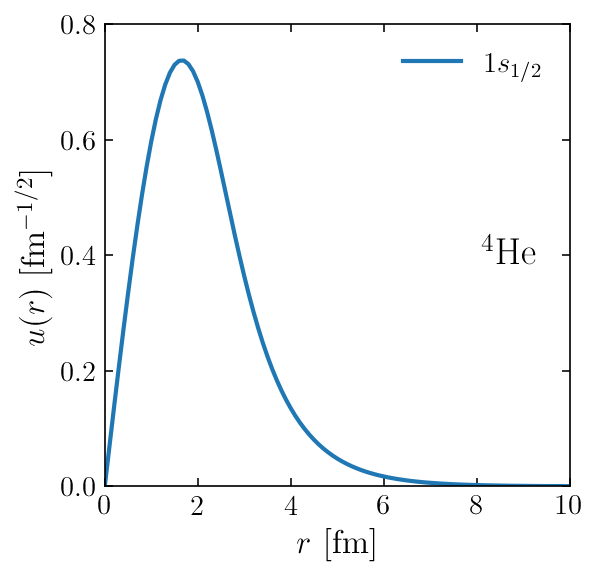

In [15]:
plot_sp_wfs_rspace(nucleus_name, Z, N, save=True)

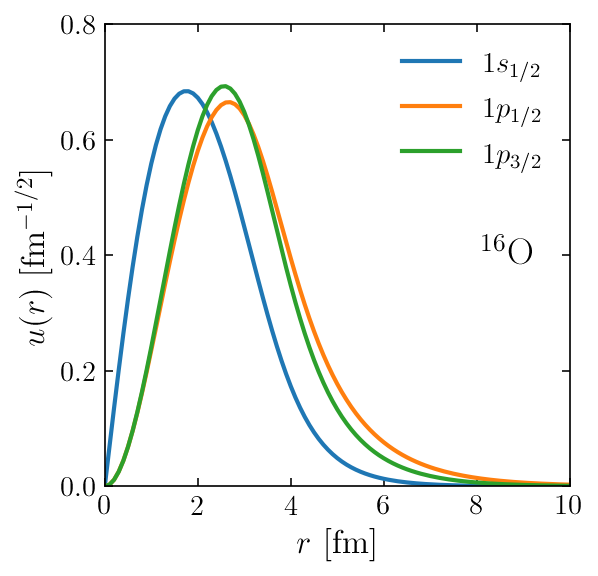

In [16]:
plot_sp_wfs_rspace('O16', 8, 8, save=True)

## Single-particle wave functions in momentum space

In [17]:
k_array, k_weights, phi_k_array = get_phi_kspace(
    nucleus_name, Z, N, 'proton', '1s0p5', print_normalization=True
)

Normalization = 1.0000000007365952.


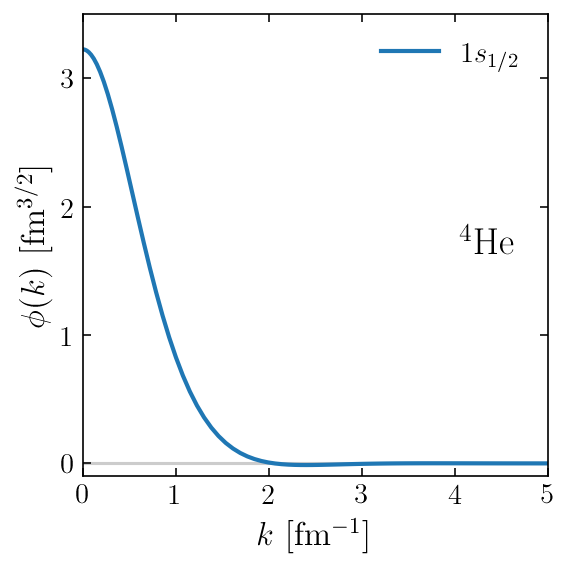

In [18]:
plot_sp_wfs_kspace(nucleus_name, Z, N, y_limits=(-0.1,3.5), save=True)

_Note, the $1s_{1/2}$ wave function is slightly negative at different points in $k$. Will that screw up calculations? Is something wrong with my Fourier transform?_

## Spectroscopic overlaps

The following calculation is based on equation (23) in the Overleaf notes.

In [19]:
def interpolate_phi_kspace(nucleon):
    """Interpolate s.p. wave functions \phi(k)."""
    
    k_array, _, phi_array = get_phi_kspace('He4', 2, 2, nucleon, '1s0p5')

    # Interpolate s.p. wave functions
    phi_func = interp1d(k_array, phi_array, kind='linear', bounds_error=False,
                        fill_value='extrapolate')

    return phi_func

In [20]:
# Note, this needs to be updated to do coupled-channels (not just 3S1-3S1)
def interpolate_deltaU_dagger(kvnn, channel, lamb, kmax, kmid, ntot, generator):
    """Interpolate \delta U^\dagger(k',k)."""

    # Set potential
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    
    # Get momentum mesh
    k_array, k_weights = potential.load_mesh()
    
    # Initial and evolved Hamiltonians
    H_initial = potential.load_hamiltonian()
    if generator == 'Block-diag':
        H_evolved = potential.load_hamiltonian('srg', generator, 1.0,
                                               lambda_bd=lamb)
    else:
        H_evolved = potential.load_hamiltonian('srg', generator, lamb)
    
    # Get SRG transformation from Hamiltonians
    U_matrix_weights = get_transformation(H_initial, H_evolved)[:ntot,:ntot]

    # Calculate \delta U^\dagger = (U - I)^\dagger
    I_matrix_weights = np.eye(ntot, ntot)
    delUdag_matrix_weights = (U_matrix_weights - I_matrix_weights).T
    delUdag_matrix = unattach_weights_from_matrix(k_array, k_weights,
                                                  delUdag_matrix_weights)
    
    # Interpolate \delta U^\dagger(k,k')
    delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix, kx=1,
                                       ky=1)

    return delUdag_func

In [21]:
def compute_deltaU_dagger_term(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                               generator='Wegner'):
    """Compute the \delta U^\dagger term in the spectroscopic overlap."""
    
    # Initialize momentum and angle meshes
    k_array, k_weights = momentum_mesh(10.0, 2.0, 120)  # Relative momenta
    K_array, K_weights = gaussian_quadrature_mesh(2.0, 40)  # CoM momenta
    x_array, x_weights = leggauss(7)  # Angles between K and k' (or K and k)
    
    # Get meshgrids for (k', k, K, x)
    kp_grid, k_grid, K_grid, x_grid = np.meshgrid(k_array, k_array, K_array,
                                                  x_array, indexing='ij')
    _, _, _, dx_grid = np.meshgrid(k_weights, k_weights, K_weights, x_weights,
                                   indexing='ij')
    
    # Get s.p. wave functions
    phi_p_func = interpolate_phi_kspace('proton')
    phi_n_func = interpolate_phi_kspace('neutron')
    
    # Evaluate product of s.p. wave functions and attach weights dx (or dy)
    # These are 4-D arrays (k', k, K, x)
    pp_kp_K_y_grid = (
        phi_p_func(
            np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
        )
        * phi_p_func(
            np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
        )
    ) * dx_grid
    pn_kp_K_y_grid = (
        phi_p_func(
            np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
        )
        * phi_n_func(
            np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
        )
    ) * dx_grid
    pp_k_K_x_grid = (
        phi_p_func(
            np.sqrt(K_grid**2/4 + k_grid**2 + k_grid*K_grid*x_grid)
        )
        * phi_p_func(
            np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
        )
    ) * dx_grid
    pn_k_K_x_grid = (
        phi_p_func(
            np.sqrt(K_grid**2/4 + k_grid**2 + k_grid*K_grid*x_grid)
        )
        * phi_n_func(
            np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
        )
    ) * dx_grid
    
    # Perform angle-averaging integrals (x and y) -> 3-D arrays (k', k, K)
    pp_kp_K_grid = 0.5 * np.sum(pp_kp_K_y_grid, axis=-1)
    pn_kp_K_grid = 0.5 * np.sum(pn_kp_K_y_grid, axis=-1)
    pp_k_K_grid = 0.5 * np.sum(pp_k_K_x_grid, axis=-1)
    pn_k_K_grid = 0.5 * np.sum(pn_k_K_x_grid, axis=-1)
    
    # Evaluate product of s.p. wave functions and attach dK K^2
    _, _, dK_grid = np.meshgrid(k_weights, k_weights, K_array**2 * K_weights,
                                indexing='ij')
    pppp_kp_k_K_grid = pp_kp_K_grid * pp_k_K_grid * dK_grid
    pnpn_kp_k_K_grid = pn_kp_K_grid * pn_k_K_grid * dK_grid
    
    # Integrate over K -> 2-D arrays (k', k)
    pppp_kp_k_grid = np.sum(pppp_kp_k_K_grid, axis=-1)
    pnpn_kp_k_grid = np.sum(pnpn_kp_k_K_grid, axis=-1)
    
    # Get \delta U^\dagger(k',k) and evaluate integrand with dk' k'^2 dk k^2
    delUdag_1S0_func = interpolate_deltaU_dagger(kvnn, '1S0', lamb, kmax,
                                                 kmid, ntot, generator)
    delUdag_1S0_grid = delUdag_1S0_func(k_array, k_array)
    delUdag_3S1_func = interpolate_deltaU_dagger(kvnn, '3S1', lamb, kmax,
                                                 kmid, ntot, generator)
    delUdag_3S1_grid = delUdag_3S1_func(k_array, k_array)
    
    dkp_grid, dk_grid = np.meshgrid(k_array**2 * k_weights,
                                    k_array**2 * k_weights, indexing='ij')
    
    integrand = (
        (pppp_kp_k_grid * delUdag_1S0_grid + 0.5 * pnpn_kp_k_grid 
         * (delUdag_1S0_grid+3*delUdag_3S1_grid))
    ) * dkp_grid * dk_grid
    
    # Integrate over k and kp -> reduced to a number at this point
    return np.sum(np.sum(integrand, axis=-1), axis=-1)

In [22]:
compute_deltaU_dagger_term(6, 1.35)

-0.06668886494761395

In [23]:
compute_deltaU_dagger_term(6, 2.0)

-0.03213484766019262

In [24]:
def spectroscopic_overlap(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                          generator='Wegner', sanity_check=False):
    """Compute the spectroscopic overlap."""
    
    # Give an option to set \delta U^\dagger term to zero for sanity check
    if sanity_check:
        delUdag_term = 0.0
    else:
        delUdag_term = compute_deltaU_dagger_term(kvnn, lamb, kmax, kmid, ntot,
                                                  generator)
        
    # Get s.p. wave function for 1s_1/2 proton in He4
    q_array, q_weights, phi_array = get_phi_kspace('He4', 2, 2, 'proton',
                                                   '1s0p5')
    
    # Y_00(\qhat) is simple
    Y_00 = 1/np.sqrt(4*np.pi)
    
    # Sum I and \delta U^\dagger terms and tack on \phi(q) Y_00(\qhat)
    return q_array, q_weights, Y_00 * phi_array * (1 + delUdag_term)

In [25]:
def spectroscopic_factor(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                         generator='Wegner', sanity_check=False):
    """Compute the normalization of the spectroscopic overlap."""
    
    # Get the spectroscopic overlap and momenta (with weights)
    q_array, q_weights, overlap_array = spectroscopic_overlap(
        kvnn, lamb, kmax, kmid, ntot, generator, sanity_check
    )
    
    return 4 * np.pi * np.sum(q_weights * q_array**2 * abs(overlap_array)**2)

In [26]:
2*spectroscopic_factor(6, 1.35, sanity_check=True)

2.0000000014731905

In [27]:
2*spectroscopic_factor(6, 1.35)

1.742139350908798

In [28]:
2*spectroscopic_factor(6, 2.0)

1.8735259076075474

In [29]:
def plot_spectroscopic_overlap(
        q_array, q_weights, overlap_array, plot_phi=False, x_limits=(0.0,10.0),
        y_limits=(1e-5,1e2), y_scale='log', save=False):
    """Plot the spectrosopic overlap as a function of momentum q."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    factor = np.sqrt(4 * np.pi * 2 * (2*np.pi)**3)
    
    # Plot just the proton overlap
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    ax.plot(q_array, overlap_array*factor, label=label_sp_state('1s0p5'),
            linewidth=2.0)
    
    if plot_phi:
        k_array, _, phi_p_array = get_phi_kspace('He4', 2, 2, 'proton', '1s0p5')
        ax.plot(k_array, phi_p_array*factor, label=r"$\phi$", linewidth=2.0)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$A(q)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_overlap_{kvnn}_{lamb}_SLy4.png'
        f.savefig(figures_directory + file_name)

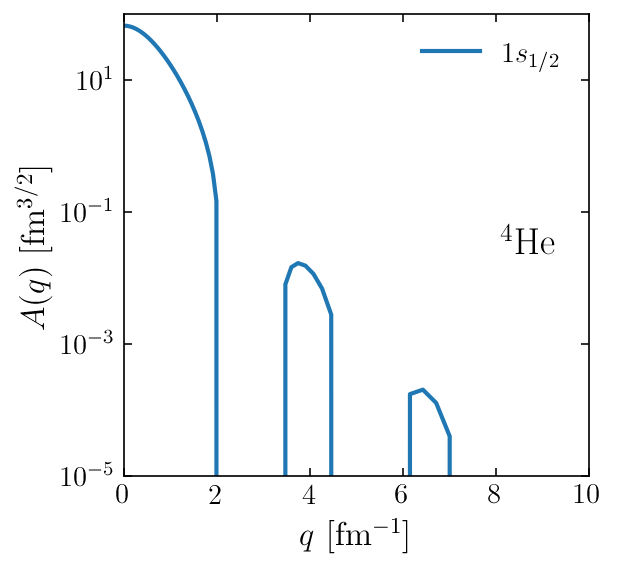

In [30]:
q_array, q_weights, overlap_array = spectroscopic_overlap(6, 1.35)
plot_spectroscopic_overlap(q_array, q_weights, overlap_array)

Updated calculation to get two-body operator using plane wave basis first, then switching to s.p. basis.

In [31]:
def spectroscopic_overlap_v2(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                             generator='Wegner', sanity_check=False):
    """Compute the spectroscopic overlap."""
    
    # Initialize momentum and angle meshes
    q_array, q_weights = momentum_mesh(10.0, 2.0, 120)  # s.p. momenta
    k_array, k_weights = momentum_mesh(10.0, 2.0, 120)  # Relative momenta
    K_array, K_weights = gaussian_quadrature_mesh(2.0, 40)  # CoM momenta
    x_array, x_weights = leggauss(7)  # Angles between q and K (or K and k)
    
    # Get meshgrids for q, k, and K (weights too)
    q_grid, k_grid, K_grid = np.meshgrid(q_array, k_array, K_array,
                                         indexing='ij')
    _, dk_grid, dK_grid = np.meshgrid(
        q_array, k_array**2 * k_weights, K_array**2 * K_weights, indexing='ij'
    )
    
    # Get s.p. wave functions
    phi_p_func = interpolate_phi_kspace('proton')
    phi_n_func = interpolate_phi_kspace('neutron')
    
    # Get \delta U^\dagger function and evaluate at (|\qvec-\Kvec/2|, k)
    delUdag_1S0_func = interpolate_deltaU_dagger(kvnn, '1S0', lamb, kmax,
                                                 kmid, ntot, generator)
    delUdag_3S1_func = interpolate_deltaU_dagger(
        kvnn, '3S1', lamb, kmax, kmid, ntot, generator
    )
    
    # Initialize integrand
    integrand_k_K = np.zeros_like(q_grid)
    
    # Do angle-averaging integrals
    for x, dx in zip(x_array, x_weights):
        
        K_minus_q = np.sqrt(K_grid**2 + q_grid**2 - 2*K_grid*q_grid*x)
        q_minus_K_over_two = np.sqrt(q_grid**2 + K_grid**2/4 + K_grid*q_grid*x)
        
        phi_p_K_minus_q = phi_p_func(K_minus_q)
        phi_n_K_minus_q = phi_n_func(K_minus_q)
        
        delUdag_1S0_grid = delUdag_1S0_func.ev(q_minus_K_over_two, k_grid)
        delUdag_3S1_grid = delUdag_3S1_func.ev(q_minus_K_over_two, k_grid)
        
        for y, dy in zip(x_array, x_weights):
            
            K_over_two_plus_k = np.sqrt(
                K_grid**2/4 + k_grid**2 + K_grid*k_grid*y
            )
            K_over_two_minus_k = np.sqrt(
                K_grid**2/4 + k_grid**2 - K_grid*k_grid*y
            )
            
            phi_p_K_over_two_plus_k = phi_p_func(K_over_two_plus_k)
            phi_p_K_over_two_minus_k = phi_p_func(K_over_two_minus_k)
            phi_n_K_over_two_minus_k = phi_n_func(K_over_two_minus_k)
            
            integrand_k_K += dx/2 * dy/2 * phi_p_K_over_two_plus_k * (
                phi_p_K_minus_q * phi_p_K_over_two_minus_k * delUdag_1S0_grid
                + 0.5 * phi_n_K_minus_q * phi_n_K_over_two_minus_k
                * (delUdag_1S0_grid + 3*delUdag_3S1_grid)
            )
            
    # Integrate over K and k
    deltaU_dag_term = np.sum(
        np.sum(dk_grid * dK_grid * integrand_k_K, axis=-1), axis=-1
    )

    # Give an option to set \delta U^\dagger term to zero for sanity check
    if sanity_check:
        deltaU_dag_term = np.zeros_like(q_array)
    
    # Integrate over k and add to \phi_p(q) for full spectroscopic overlap
    return q_array, q_weights, 1/np.sqrt(4*np.pi) * (
        phi_p_func(q_array) + 2*deltaU_dag_term
    )

In [32]:
def spectroscopic_factor_v2(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                            generator='Wegner', sanity_check=False):
    """Compute the normalization of the spectroscopic overlap."""
    
    # Get the spectroscopic overlap and momenta (with weights)
    q_array, q_weights, overlap_array = spectroscopic_overlap_v2(
        kvnn, lamb, kmax, kmid, ntot, generator, sanity_check
    )
    
    return 4 * np.pi * np.sum(q_weights * q_array**2 * abs(overlap_array)**2)

In [33]:
spectroscopic_factor_v2(6, 1.35, sanity_check=True)

1.0015663675253905

In [34]:
spectroscopic_factor_v2(6, 1.35)

1.1387345187432543

In [35]:
spectroscopic_factor_v2(6, 2.0)

0.9659994673596157

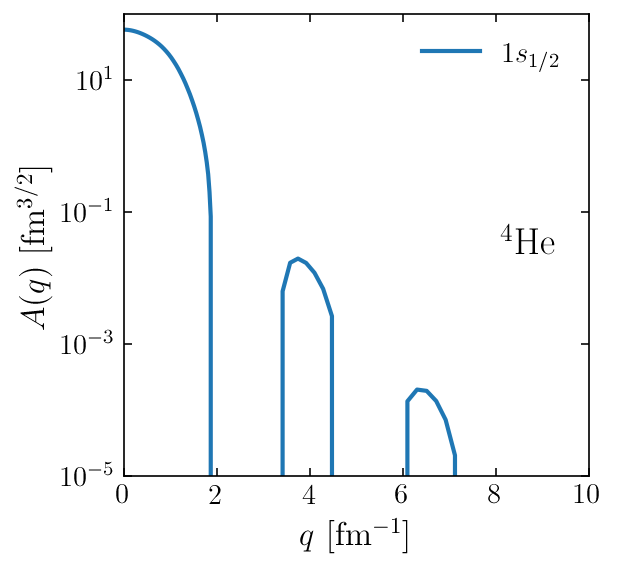

In [36]:
# Plot spectroscopic overlap
q_array, q_weights, overlap_array = spectroscopic_overlap_v2(6, 1.35)
plot_spectroscopic_overlap(q_array, q_weights, overlap_array)

## Bug testing

In [37]:
class Debug:
    
    def __init__(
            self, nucleus_name='He4', Z=2, N=2, sp_state='1s0p5', kvnn=6,
            lamb=1.35, generator='Wegner', approach='1', kmax=15.0, kmid=3.0,
            ntot=120):
        
        self.nucleus_name = nucleus_name
        self.Z = Z
        self.N = N
        self.sp_state = sp_state
        self.kvnn = kvnn
        self.lamb = lamb
        self.generator = generator
        self.approach = approach
        self.kmax = kmax
        self.kmid = kmid
        self.ntot = ntot
        
    def get_phi_kspace(
            self, nucleon, kmax=15.0, kmid=3.0, ntot=120,
            print_phi_r_array=False, print_phi_r_norm=False,
            print_phi_k_array=False, print_phi_k_norm=False):

        # Set momentum mesh
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        r_array, phi_r_array = get_phi_rspace(self.nucleus_name, self.Z, self.N,
                                              nucleon, self.sp_state)
        dr = r_array[2] - r_array[1]  # Assuming linear spacing in coordinates
        
        if print_phi_r_array:
            for i,j in zip(r_array, phi_r_array):
                print(i,j)
                
        if print_phi_r_norm:
            phi_r_norm = np.sum(dr*phi_r_array**2)
            print(f"r-space normalization = {phi_r_norm}.")
    
        # Fourier-transform the wave function to momentum space
        l = convert_l_to_int(self.sp_state)
        phi_k_array = (hankel_transformation(l, k_array, r_array, dr)
                       @ phi_r_array)
        
        if print_phi_k_array:
            for i,j in zip(k_array, phi_k_array):
                print(i,j)
    
        # These are normalized as \int dk k^2 |\phi(k)|^2 = 1
        if print_phi_k_norm:
            phi_k_norm = np.sum(k_weights*k_array**2*phi_k_array**2)
            print(f"k-space normalization = {phi_k_norm}.")
            
        return k_array, k_weights, phi_k_array
    
    def plot_phi_kspace(self, k_array, phi_k_array, x_limits=(0.0,5.0),
                        y_limits=(-0.1,4.0)):
    
        # Initialize figure
        plt.close('all')
        f, ax = plt.subplots(figsize=(4, 4))
    
        ax.plot(k_array, phi_k_array, label=label_sp_state(self.sp_state),
                linewidth=2.0)
        
        # Add horizontal line at y=0
        ax.axhline(0.0, color='gray', alpha=0.4, zorder=1)
        
        # Set axes limits
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)

        # Set axes labels
        ax.set_xlabel(r"$k$ [fm" + r'$^{-1}$' + ']', fontsize=16)
        ax.set_ylabel(r"$\phi(k)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

        # Set legend
        ax.legend(loc='upper right', fontsize=14, frameon=False)

        # Add nucleus label
        ax.add_artist(
            AnchoredText(label_nucleus(nucleus_name), loc='center right',
                         prop=dict(size=18), frameon=False)
        )
        
    def interpolate_phi_kspace(
            self, nucleon, kind='linear', bounds_error=False,
            fill_value='extrapolate', compare=False, print_normalization=False):
        
        k_array, _, phi_array = self.get_phi_kspace(nucleon)

        # Interpolate s.p. wave functions
        phi_func = interp1d(k_array, phi_array, kind=kind,
                            bounds_error=bounds_error, fill_value=fill_value)
        
        # Compare to phi_array using a different mesh
        if compare:
            k_array_new, k_weights_new = momentum_mesh(10.0, 2.0, 120)
            phi_array_new = phi_func(k_array_new)
            for i,j,k,l in zip(k_array_new, phi_array_new, k_array, phi_array):
                print(i,j,k,l)
                
        if print_normalization:    
            phi_k_norm = np.sum(k_weights_new*k_array_new**2*phi_array_new**2)
            print(f"Normalization on different mesh = {phi_k_norm}.")

        return phi_func
    
    # This needs to be capable of doing coupled channels correctly
    def interpolate_deltaU_dagger(self, channel, kind='linear'):

#         # TESTING
#         if len(channel) > 3:
#             channel_full = channel
#             channel = '3S1'

        # Set potential
        potential = Potential(self.kvnn, channel, self.kmax, self.kmid,
                              self.ntot)
    
        # Get momentum mesh
        k_array, k_weights = potential.load_mesh()
    
        # Initial and evolved Hamiltonians
        H_initial = potential.load_hamiltonian()
        if self.generator == 'Block-diag':
            H_evolved = potential.load_hamiltonian('srg', self.generator, 1.0,
                                                   lambda_bd=self.lamb)
        else:
            H_evolved = potential.load_hamiltonian('srg', self.generator,
                                                   self.lamb)
    
        # Get SRG transformation from Hamiltonians
        U_matrix_weights = get_transformation(H_initial, H_evolved)[:self.ntot,
                                                                    :self.ntot]
    #     # TESTING
    #     if channel_full == '3D1-3D1':
    #         U_matrix_weights = get_transformation(
    #             H_initial, H_evolved
    #         )[ntot:2*ntot,ntot:2*ntot]
    #     elif channel_full == '3S1-3D1':
    #         U_matrix_weights = get_transformation(
    #             H_initial, H_evolved
    #         )[:ntot,ntot:2*ntot]
    #     else:
    #         U_matrix_weights = get_transformation(H_initial, H_evolved)[:ntot,:ntot]

    #     # Coupled-channel?
    #     cc_bool = coupled_channel(channel)

        # Isolate 2-body term
        I_matrix_weights = np.eye(self.ntot, self.ntot)
    #     if cc_bool:
    #         I_matrix_weights = np.eye(2 * ntot, 2 * ntot)
    #     else:
    #         I_matrix_weights = np.eye(ntot, ntot)
        delUdag_matrix_weights = (U_matrix_weights - I_matrix_weights).T
        delUdag_matrix = unattach_weights_from_matrix(k_array, k_weights,
                                                      delUdag_matrix_weights)
    
        # Interpolate \delta U^\dagger(k,k')
        if kind == 'linear':
            delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix,
                                               kx=1, ky=1)
        elif kind == 'cubic':
            delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix,
                                               kx=3, ky=3)
            
        # You might want to check what these matrices look like on different
        # meshes using the interpolating function

        return delUdag_func
    
    def compute_deltaU_dagger_term(
            self, kmax=10.0, kmid=2.0, ntot_k=120, Kmax=2.0, ntot_K=40,
            ntot_x=7, phi_interp_kind='linear', bounds_error=False,
            fill_value='extrapolate', print_max_mins=False,
            absolute_value=False, deltaUdag_interp_kind='linear',
            four_pi_factor=True):

        # Initialize momentum and angle meshes
        # Relative momenta
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot_k)
        # CoM momenta
        K_array, K_weights = gaussian_quadrature_mesh(Kmax, ntot_K)
        # Angles between K and k' (or K and k)
        x_array, x_weights = leggauss(ntot_x)
    
        # Get meshgrids for (k', k, K, x)
        kp_grid, k_grid, K_grid, x_grid = np.meshgrid(k_array, k_array, K_array,
                                                      x_array, indexing='ij')
        _, _, _, dx_grid = np.meshgrid(k_weights, k_weights, K_weights,
                                       x_weights, indexing='ij')
    
        # Get s.p. wave functions
        phi_p_func = self.interpolate_phi_kspace(
            'proton', kind=phi_interp_kind, bounds_error=bounds_error,
            fill_value=fill_value
        )
        phi_n_func = self.interpolate_phi_kspace(
            'neutron', kind=phi_interp_kind, bounds_error=bounds_error,
            fill_value=fill_value
        )
        
        if print_max_mins:
            mx = np.amax(phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
            ))
            mn = np.amin(phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
            ))
            print(f"Max of \phi(|K/2+k'|) = {mx}.")
            print(f"Min of \phi(|K/2+k'|) = {mn}.")
        
        if absolute_value:
            phi_p_array_1 = abs(phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
            ))
            phi_p_array_2 = abs(phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
            ))
            phi_n_array_1 = abs(phi_n_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
            ))
            phi_p_array_3 = abs(phi_p_func(
                np.sqrt(K_grid**2/4 + k_grid**2 + k_grid*K_grid*x_grid)
            ))
            phi_p_array_4 = abs(phi_p_func(
                np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
            ))
            phi_n_array_2 = abs(phi_n_func(
                np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
            ))
        else:
            phi_p_array_1 = phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
            )
            phi_p_array_2 = phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
            )
            phi_n_array_1 = phi_n_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
            )
            phi_p_array_3 = phi_p_func(
                np.sqrt(K_grid**2/4 + k_grid**2 + k_grid*K_grid*x_grid)
            )
            phi_p_array_4 = phi_p_func(
                np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
            )
            phi_n_array_2 = phi_n_func(
                np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
            )
            
        # Evaluate product of s.p. wave functions and attach weights dx (or dy)
        # These are 4-D arrays (k', k, K, x)
        pp_kp_K_y_grid = phi_p_array_1 * phi_p_array_2 * dx_grid
        pn_kp_K_y_grid = phi_p_array_1 * phi_n_array_1 * dx_grid
        pp_k_K_x_grid = phi_p_array_3 * phi_p_array_4 * dx_grid
        pn_k_K_x_grid = phi_p_array_3 * phi_n_array_2 * dx_grid
            
        # Perform angle-averaging integrals (x and y) -> 3-D arrays (k', k, K)
        pp_kp_K_grid = 0.5 * np.sum(pp_kp_K_y_grid, axis=-1)
        pn_kp_K_grid = 0.5 * np.sum(pn_kp_K_y_grid, axis=-1)
        pp_k_K_grid = 0.5 * np.sum(pp_k_K_x_grid, axis=-1)
        pn_k_K_grid = 0.5 * np.sum(pn_k_K_x_grid, axis=-1)
    
        # Evaluate product of s.p. wave functions and attach dK K^2
        _, _, dK_grid = np.meshgrid(k_weights, k_weights, K_array**2*K_weights,
                                    indexing='ij')
        pppp_kp_k_K_grid = pp_kp_K_grid * pp_k_K_grid * dK_grid
        pnpn_kp_k_K_grid = pn_kp_K_grid * pn_k_K_grid * dK_grid
    
        # Integrate over K -> 2-D arrays (k', k)
        pppp_kp_k_grid = np.sum(pppp_kp_k_K_grid, axis=-1)
        pnpn_kp_k_grid = np.sum(pnpn_kp_k_K_grid, axis=-1)
    
        # Get \delta U^\dagger(k',k) and evaluate integrand with dk' k'^2 dk k^2
        delUdag_1S0_func = self.interpolate_deltaU_dagger(
            '1S0', kind=deltaUdag_interp_kind
        )
        delUdag_1S0_grid = delUdag_1S0_func(k_array, k_array)
        delUdag_3S1_func = self.interpolate_deltaU_dagger(
            '3S1', kind=deltaUdag_interp_kind
        )
        delUdag_3S1_grid = delUdag_3S1_func(k_array, k_array)
    
        dkp_grid, dk_grid = np.meshgrid(k_array**2 * k_weights,
                                        k_array**2 * k_weights, indexing='ij')
    
        integrand = (
            (pppp_kp_k_grid * delUdag_1S0_grid + 0.5 * pnpn_kp_k_grid 
             * (delUdag_1S0_grid+3*delUdag_3S1_grid))
        ) * dkp_grid * dk_grid
    
        # Integrate over k and kp -> reduced to a number at this point
        if four_pi_factor:
            factor = 4*np.pi
        else:
            factor = 1
        return factor * np.sum(np.sum(integrand, axis=-1), axis=-1)
    
    def spectroscopic_overlap(
            self, sanity_check=False, kmax=10.0, kmid=2.0, ntot_k=120, Kmax=2.0,
            ntot_K=40, ntot_x=7, phi_interp_kind='linear', absolute_value=False,
            deltaUdag_interp_kind='linear',
            four_pi_factor=True):
        
        # Get s.p. wave function for 1s_1/2 proton in He4
        q_array, q_weights, phi_array = self.get_phi_kspace(
            'proton', kmax=self.kmax, kmid=self.kmid, ntot=self.ntot
        )
    
        # Y_00(\qhat) is simple
        Y_00 = 1/np.sqrt(4*np.pi)
        
        I_array = Y_00 * phi_array
        
        if sanity_check:
            
            deltaU_dag_array = np.zeros_like(phi_array)
            
        else:
        
            if self.approach == '1':
            
                deltaU_dag_term = self.compute_deltaU_dagger_term(
                    kmax, kmid, ntot_k, Kmax, ntot_K, ntot_x, phi_interp_kind,
                    absolute_value=absolute_value,
                    deltaUdag_interp_kind=deltaUdag_interp_kind,
                    four_pi_factor=four_pi_factor
                )
                
                deltaU_dag_array = Y_00 * phi_array * deltaU_dag_term
                
        return q_array, q_weights, I_array + deltaU_dag_array
    
    def spectroscopic_factor(
            self, sanity_check=False, kmax=10.0, kmid=2.0, ntot_k=120, Kmax=2.0,
            ntot_K=40, ntot_x=7, phi_interp_kind='linear', absolute_value=False,
            deltaUdag_interp_kind='linear',
            four_pi_factor=True):
        
        # Get the spectroscopic overlap and momenta (with weights)
        q_array, q_weights, overlap_array = self.spectroscopic_overlap(
            sanity_check, kmax, kmid, ntot_k, Kmax, ntot_K, ntot_x,
            phi_interp_kind, absolute_value, deltaUdag_interp_kind,
            four_pi_factor
        )
    
        return 4*np.pi * np.sum(q_weights * q_array**2 * abs(overlap_array)**2)   

In [38]:
def debug_spectroscopic_overlap_v2(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                                   generator='Wegner', sanity_check=False):
    
    # Initialize momentum and angle meshes
    q_array, q_weights = momentum_mesh(10.0, 2.0, 120)  # s.p. momenta
    k_array, k_weights = momentum_mesh(10.0, 2.0, 120)  # Relative momenta
    K_array, K_weights = gaussian_quadrature_mesh(2.0, 40)  # CoM momenta
    x_array, x_weights = leggauss(7)  # Angles between q and K (or K and k)
    
    # Get meshgrids for q, k, and K (weights too)
    q_grid, k_grid, K_grid = np.meshgrid(q_array, k_array, K_array,
                                         indexing='ij')
    _, dk_grid, dK_grid = np.meshgrid(
        q_array, k_array**2 * k_weights, K_array**2 * K_weights, indexing='ij'
    )
    
    # Get s.p. wave functions
    phi_p_func = interpolate_phi_kspace('proton')
    phi_n_func = interpolate_phi_kspace('neutron')
    
    # Get \delta U^\dagger function and evaluate at (|\qvec-\Kvec/2|, k)
    delUdag_1S0_func = interpolate_deltaU_dagger(kvnn, '1S0', lamb, kmax,
                                                 kmid, ntot, generator)
    delUdag_3S1_func = interpolate_deltaU_dagger(
        kvnn, '3S1', lamb, kmax, kmid, ntot, generator
    )
#     # TESTING
#     delUdag_3S1_3S1_func = interpolate_deltaU_dagger(
#         kvnn, '3S1-3S1', lamb, kmax, kmid, ntot, generator
#     )
#     delUdag_3S1_3D1_func = interpolate_deltaU_dagger(
#         kvnn, '3S1-3D1', lamb, kmax, kmid, ntot, generator
#     )
    
    # Initialize integrand
    integrand_k_K = np.zeros_like(q_grid)
    
    # Do angle-averaging integrals
    for x, dx in zip(x_array, x_weights):
        
        K_minus_q = np.sqrt(K_grid**2 + q_grid**2 - 2*K_grid*q_grid*x)
        q_minus_K_over_two = np.sqrt(q_grid**2 + K_grid**2/4 + K_grid*q_grid*x)
        
        phi_p_K_minus_q = phi_p_func(K_minus_q)
        phi_n_K_minus_q = phi_n_func(K_minus_q)
        
        delUdag_1S0_grid = delUdag_1S0_func.ev(q_minus_K_over_two, k_grid)
        delUdag_3S1_grid = delUdag_3S1_func.ev(q_minus_K_over_two, k_grid)
#         # TESTING
#         delUdag_3S1_3S1_grid = delUdag_3S1_3S1_func.ev(q_minus_K_over_two,
#                                                        k_grid)
#         delUdag_3S1_3D1_grid = delUdag_3S1_3D1_func.ev(q_minus_K_over_two,
#                                                        k_grid)
        
        for y, dy in zip(x_array, x_weights):
            
            K_over_two_plus_k = np.sqrt(
                K_grid**2/4 + k_grid**2 + K_grid*k_grid*y
            )
            K_over_two_minus_k = np.sqrt(
                K_grid**2/4 + k_grid**2 - K_grid*k_grid*y
            )
            
            phi_p_K_over_two_plus_k = phi_p_func(K_over_two_plus_k)
            phi_p_K_over_two_minus_k = phi_p_func(K_over_two_minus_k)
            phi_n_K_over_two_minus_k = phi_n_func(K_over_two_minus_k)
            
            integrand_k_K += dx/2 * dy/2 * phi_p_K_over_two_plus_k * (
                phi_p_K_minus_q * phi_p_K_over_two_minus_k * delUdag_1S0_grid
                + 0.5 * phi_n_K_minus_q * phi_n_K_over_two_minus_k
                * (delUdag_1S0_grid + 3*delUdag_3S1_grid)
            )
#             # TESTING
#             integrand_k_K += dx/2 * dy/2 * phi_p_K_over_two_plus_k * (
#                 phi_p_K_minus_q * phi_p_K_over_two_minus_k * delUdag_1S0_grid
#                 + 0.5 * phi_n_K_minus_q * phi_n_K_over_two_minus_k
#                 * (
#                     delUdag_1S0_grid + 3*delUdag_3S1_3S1_grid
#                     + 3*delUdag_3S1_3D1_grid
#                 )
#             )
            
    # Integrate over K and k
    deltaU_dag_term = np.sum(
        np.sum(dk_grid * dK_grid * integrand_k_K, axis=-1), axis=-1
    )

    # Give an option to set \delta U^\dagger term to zero for sanity check
    if sanity_check:
        deltaU_dag_term = np.zeros_like(q_array)
    
    # Integrate over k and add to \phi_p(q) for full spectroscopic overlap
    return q_array, q_weights, 1/np.sqrt(4*np.pi) * (
        phi_p_func(q_array) + 2*deltaU_dag_term
    )

In [39]:
def debug_plot_spectroscopic_overlap(
        q_array, q_weights, overlap_array, plot_phi=False, x_limits=(0.0,10.0),
        y_limits=(1e-5,1e2), y_scale='log', save=False):

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # TESTING
    # Try plotting \sqrt((2j+1)*(4\pi)) * overlap -> \int dq q^2 |overlap|^2 = (2j+1)
#     factor = np.sqrt(2 * 4 * np.pi)
#     factor = np.sqrt(4 * np.pi * 2 * (2*np.pi)**3)
#     factor = 1
    factor = (2*np.pi)**3
    
    # Plot just the proton overlap
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    ax.plot(q_array, overlap_array*factor, label=label_sp_state('1s0p5'),
            linewidth=2.0)
    
    if plot_phi:
        k_array, _, phi_p_array = get_phi_kspace('He4', 2, 2, 'proton', '1s0p5')
        ax.plot(k_array, phi_p_array*factor, label=r"$\phi$", linewidth=2.0)
    
#     # TESTING
#     print(np.sum(abs(overlap_array*factor)**2*q_weights*q_array**2)/(2*np.pi)**3)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$A(q)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_overlap_{kvnn}_{lamb}_SLy4.png'
        f.savefig(figures_directory + file_name)

In [40]:
# # Plot the second term as a function of q
# q_array, q_weights, overlap_array = spectroscopic_overlap_v2(6, 1.35)

# phi_p_func = interpolate_phi_kspace('proton')

# second_term = overlap_array - phi_p_func(q_array)/np.sqrt(4*np.pi)
# # for iq, iUdag in zip(q_array, second_term):
# #     print(iq, iUdag)

# plot_spectroscopic_overlap(q_array, q_weights, second_term, plot_phi=True,
#                            y_scale='linear', x_limits=(0,5), y_limits=(-45,810))

In [41]:
db = Debug()

In [42]:
# # Test normalization of \phi(k) for the standard mesh
# k_array, k_weights, phi_k_array = db.get_phi_kspace(
#     'proton', print_phi_r_norm=True, print_phi_k_norm=True
# )

In [43]:
# # Plot \phi(k) for the standard mesh
# db.plot_phi_kspace(k_array, phi_k_array, y_limits=(-0.1,3.5))

In [44]:
# # Test normalization of \phi(k) for another mesh
# k_array, k_weights, phi_k_array = db.get_phi_kspace(
#     'proton', kmax=10.0, kmid=2.0, ntot=120, print_phi_r_norm=True,
#     print_phi_k_norm=True
# )

In [45]:
# # Plot \phi(k) for another mesh
# db.plot_phi_kspace(k_array, phi_k_array, y_limits=(-0.1,3.5))

In [46]:
# # Default interpolation of \phi(k)
# phi_func = db.interpolate_phi_kspace(
#     'proton', kind='linear', bounds_error=False, fill_value='extrapolate',
#     compare=True, print_normalization=True
# )

In [47]:
# phi_func = db.interpolate_phi_kspace(
#     'proton', kind='cubic', bounds_error=False, fill_value='extrapolate',
#     compare=True, print_normalization=True
# )

In [48]:
# # This should give a ValueError since the new mesh goes to a lower value than
# # the previous
# phi_func = db.interpolate_phi_kspace(
#     'proton', kind='linear', bounds_error=True, fill_value=np.nan,
#     compare=True)

In [49]:
# phi_func = db.interpolate_phi_kspace(
#     'proton', kind='linear', bounds_error=False, fill_value=0.0, compare=True,
#     print_normalization=True
# )

In [50]:
# # Default case
# db.compute_deltaU_dagger_term(print_max_mins=True, four_pi_factor=True)

In [51]:
# # No factor of 4\pi
# db.compute_deltaU_dagger_term(four_pi_factor=False)

In [52]:
# # Prevent \phi(k)'s' from being negative
# db.compute_deltaU_dagger_term(absolute_value=True)

In [53]:
# # Different k mesh
# db.compute_deltaU_dagger_term(kmax=8.0, kmid=2.0, ntot_k=120,
#                               print_max_mins=True)

In [54]:
# # Different K mesh
# db.compute_deltaU_dagger_term(Kmax=3.0, ntot_K=60, print_max_mins=True)

In [55]:
# # Different x mesh
# db.compute_deltaU_dagger_term(ntot_x=11, print_max_mins=True)

In [56]:
# # Cubic interpolation for \phi
# db.compute_deltaU_dagger_term(print_max_mins=True, phi_interp_kind='cubic')

In [57]:
# # Cubic interpolation for \delta U^\dagger
# db.compute_deltaU_dagger_term(deltaUdag_interp_kind='cubic')

In [58]:
# Compute spectroscopic factor for default case
db.spectroscopic_factor()

0.026232015726205437

In [59]:
# Sanity check (no \delta U^\dagger term)
db.spectroscopic_factor(sanity_check=True)

1.0000000007365952

In [60]:
# No factor 4\pi
db.spectroscopic_factor(four_pi_factor=False)

0.871069675454399

In [61]:
# Prevent \phi(k)'s' from being negative
db.spectroscopic_factor(absolute_value=True, four_pi_factor=False)

0.8695342955738943

In [62]:
# Different k mesh
db.spectroscopic_factor(kmax=8.0, kmid=2.0, ntot_k=120, four_pi_factor=False)

0.8710696916070022

In [63]:
# Different K mesh
db.spectroscopic_factor(Kmax=3.0, ntot_K=60, four_pi_factor=False)

0.8694167244235828

In [64]:
# Different x mesh
db.spectroscopic_factor(ntot_x=11, four_pi_factor=False)

0.8710698215744006

In [65]:
# Cubic interpolation for \phi
db.spectroscopic_factor(phi_interp_kind='cubic', four_pi_factor=False)

0.871720450275027

In [66]:
# Cubic interpolation for \delta U^\dagger
db.spectroscopic_factor(deltaUdag_interp_kind='cubic', four_pi_factor=False)

0.8710204040186101